# Synchronous Advantage Actor-Critic (A2C)

We will be implementing the actor-critic method Synchronous Advantage Actor-Critic (A2C). A2C is a synchronous version of the asynchronous algorithm A3C.  We will adapt the actor-critic method by replacing the TD error value with the advantage value in the policy gradient update. We will also be running multiple environments in parallel. The updates will be performed in a Monte-Carlo way, all the actors will need to enter a terminal state before the policy and value functions can be updated. The advantage function, $A^{\pi}$, following policy $\pi$ is defined by:
$$A^{\pi} = Q^{\pi}(s_t, a_t) - V^{\pi}(s_t),$$
where $Q^{\pi}(s_t, a_t)$ is the action-value function following policy $\pi$ and $V^{\pi}(s_t)$ is the state-value function following policy $\pi$. The advantage function essentially measures the advantage gained (or lost) by taking the action $a_t$ in state $s_t$ over the average return of all immediate actions, and then following policy $\pi$ in the following states. We don't know the absolute value of the advantage, $A^{\pi}$, hence we need to find an advantage estimate, $\hat{A}$, as a substitute.

The advantage estimate used in A2C/A3C is given by:
$$\hat{A}_{t} = G_t - \hat{v}(S_t, w),$$ 
where $G_t$ is the discounted return for terminal episodes or the bootstrapped return for non-terminal episodes, and $\hat{v}(S_t, w)$ is the value estimate given state $S_t$ and parameters $w$. The bias-variance trade-off can be finetuned by altering the discount rate $\gamma$. Larger discount/decay rates lead to higher variance and lower bias and lower discount/decay rates lead to lower variance and higher bias. 

The state-value function parameter update is given by:
$$w \leftarrow w + \alpha^{w}\nabla\hat{A}_{t}^{2},$$
where $\alpha$ is the step-size/learning rate.

The policy function update is given by:
$$\theta \leftarrow \theta + \alpha^{\theta} \nabla_\theta \log(\pi_\theta(a_t | s_t))\hat{A}_{t}.$$



For more information on A2C/A3C, see the original A3C paper [1] [Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/abs/1602.01783), the notebook [2] [RL-Adventure-2 Actor-Critic Notebook](https://github.com/higgsfield/RL-Adventure-2/blob/master/1.actor-critic.ipynb).


In [497]:
import os
import random
import numpy as np
from functools import partial
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import jax
import flax.linen as nn
from jax import grad, value_and_grad
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from vec_env.subproc_vec_env import SubprocVecEnv

In [498]:
# Type of environment, options include:
# CartPole-v1, MountainCar-v0
ENV_TYPE = "CartPole-v1"
# Choose number of parallel environments, 
# don't exceed the number of computer threads
num_envs = 10

# Save videos from training
SAVE_VIDEOS = False
VIDEOS_ROOT_DIR = './videos/a2c_discrete/'

In [499]:
def make_env(env_id):
    """
    Returns a single environment object, 
    which will be used for parallel execution.
    """
    def _init():
        env = gym.make(env_id)
        return env
    return _init

In [500]:
# Create multiple envs for parallel execution
envs = SubprocVecEnv([make_env(ENV_TYPE) for _ in range(num_envs)])

num_actions = envs.action_space.n
obs_dims = envs.observation_space.shape
obs_upper_bounds = envs.observation_space.high
obs_lower_bounds = envs.observation_space.low

## Create The Policy 

In [501]:
class _policy_fn(nn.Module):
    """
    Policy function is an MLP used to choose the 
    best possible discrete action given the observations from the state.
    Each discrete action is given a probability from 0-1.
    The probability distribution can then be used 
    to stocastically choose the next action.  
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(num_actions)(x)
        return jax.nn.softmax(x)

# Create the model object
policy_fn = _policy_fn()
# Display the model details
dummy_x = envs.reset()
dummy_x = jnp.array(list(dummy_x[:, 0]))
rng_key = jax.random.PRNGKey(64)
print(policy_fn.tabulate(rng_key, dummy_x))


                               _policy_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module     ┃ inputs          ┃ outputs         ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ _policy_fn │ float32[10,4]   │ float32[10,2]   │                   │
├─────────┼────────────┼─────────────────┼─────────────────┼───────────────────┤
│ Dense_0 │ Dense      │ float32[10,4]   │ float32[10,256] │ bias:             │
│         │            │                 │                 │ float32[256]      │
│         │            │                 │                 │ kernel:           │
│         │            │                 │                 │ float32[4,256]    │
│         │            │                 │                 │                   │
│         │            │                 │                 │ 1,280 (5.1 KB)    │
├─────────┼────────────┼───

In [502]:
class _value_fn(nn.Module):
    """
    Value function is an MLP used to predict the expected return (value) 
    given the observations from the state.
    The value can then be used for bootstrapping, and/or 
    calculating the advantage from action chosen in the state. 
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Create the model object
value_fn = _value_fn()
# Display the model details
print(value_fn.tabulate(rng_key, dummy_x))


                               _value_fn Summary                                
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs          ┃ outputs         ┃ params             ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│         │ _value_fn │ float32[10,4]   │ float32[10,1]   │                    │
├─────────┼───────────┼─────────────────┼─────────────────┼────────────────────┤
│ Dense_0 │ Dense     │ float32[10,4]   │ float32[10,256] │ bias: float32[256] │
│         │           │                 │                 │ kernel:            │
│         │           │                 │                 │ float32[4,256]     │
│         │           │                 │                 │                    │
│         │           │                 │                 │ 1,280 (5.1 KB)     │
├─────────┼───────────┼─────────────────┼─────────────────┼────────────────────┤
│ Dense_1 │ Dense     │ flo

In [503]:
def test_model(policy_variables, env, rng_key):
    """
    Runs a single episode following the policy function, 
    then returns the episodes rewards and steps.
    """

    terminated, truncated = False, False
    episode_rewards = []
    steps = 0

    state, _ = env.reset()
    while not (terminated or truncated):
            steps += 1
            # Select the action following the parametrized policy
            action_dist = policy_fn.apply(policy_variables, state)
            action_dist = jnp.array(action_dist).astype(jnp.float64)
            # Divide by the total to ensure the values sum to one
            action_dist /= action_dist.sum()
            rng_key, subkey = jax.random.split(rng_key)
            action = jax.random.choice(subkey, jnp.arange(num_actions), p=action_dist)
            action = np.array(action)
            next_state, reward, terminated, truncated, info = env.step(action)

            episode_rewards.append(reward)

            state = next_state
    episode_rewards = np.array(episode_rewards)
    return steps, episode_rewards

    

In [504]:
def get_returns(
    gamma, next_value, rewards, done
):
    """
    Get discounted returns from rewards for each environment.
    Args:
        gamma: trajectory discount (scalar).
        next_value: value functions bootstrapped return for next state.
        rewards: agent rewards of taking actions in the environment.
        done: flag list for end of episode, 
            False indicates terminated, and True not terminated.
    Returns:
        Array of returns for each environment at each step.
    """
    batch_size = len(done)
    rewards = jnp.array(rewards)
    done = jnp.array(done)

    R = jnp.squeeze(next_value)
    returns = []

    for t in reversed(range(batch_size)):
        R = rewards[t] + (gamma * R * done[t])
        returns.append(R)

    returns = jnp.array(list(reversed(returns)))
    return returns

In [505]:
def loss_fn(value_variables, policy_variables, rng_key, gamma, max_steps, env_returns, env_steps):
    """
    Runs a single episode in a Monte-Carlo way, 
    then calculates the actor and critic losses, 
    which are then combined and returned.
    The gradients on this loss function are then used 
    to update the policy and actor functions.
    Args:
        value_variables: Value functions model parameters.
        policy_variables: Policy functions model parameters.
        rng_key: Random number generator key.
        gamma: Discount rate for discounting returns.
        max_steps: Limit on the number of steps in an episode.
        env_returns: List containing the returns from all environments each episode.
        env_steps: List containing the steps from all environments each episode.
    Returns:
        Combined loss of the value and actor functions.
    """
    terminated, truncated, term_or_trunc = jnp.repeat(False, num_envs), jnp.repeat(False, num_envs), jnp.repeat(False, num_envs)
    episode_log_probs = []
    episode_values = []
    episode_rewards = []
    done_flag = []
    steps = 0

    states = envs.reset()
    states = np.array(list(states[:, 0]))
    # Generate an episode following the policy
    while not term_or_trunc.all() and steps < max_steps:
        steps += 1
        # Select the action following the parametrized policy
        action_dists = policy_fn.apply(policy_variables, states)
        action_dists = jnp.array(action_dists).astype(jnp.float32)
        # Divide by the total to ensure the values sum to one
        action_dists /= action_dists.sum(axis=1)[..., None]
        # Stocastically choose the next action based on the probability distribution
        actions = []
        for dist in action_dists:
            rng_key, subkey = jax.random.split(rng_key)
            action = jax.random.choice(subkey, jnp.arange(num_actions), p=dist)
            actions.append(action)
        actions = np.array(actions)
        
        next_states, rewards, terminated, truncated, info = envs.step(actions)
        # Check if env was terminated or truncated in this episode or one of the previous episodes 
        term_or_trunc = jnp.array([term or trunc or t_or_t for term, trunc, t_or_t in zip(terminated, truncated, term_or_trunc)])
        done_flag.append(jnp.invert(term_or_trunc))
        # If the episode previously ended, then set the reward to 0
        rewards = jnp.array([reward if not t_or_t else 0 for reward, t_or_t in zip(rewards, term_or_trunc)])
        episode_rewards.append(rewards)
        # Log probabilities are needed for the actor loss
        log_probs = jnp.array([jnp.log(dist[action_index]) for dist, action_index in zip(action_dists, actions)])
        episode_log_probs.append(log_probs)
        # Entropy is used in the loss function to prevent the model from becoming too deterministic
        entropy = jnp.array([-jnp.sum(dist * jnp.log(dist)) for dist in action_dists])
        # Estimate the values given the states, then set all terminated states value to 0
        values = value_fn.apply(value_variables, states)
        values = jnp.squeeze(values)
        values = [value if not t_or_t else 0.0 for value, t_or_t in zip(jnp.array(values), term_or_trunc)]
        values = jnp.array(values, dtype=jnp.float32)
        episode_values.append(values)

        states = next_states

    env_returns.append(list(np.array(episode_rewards).sum(axis=0)))
    env_steps.append(list(np.array(done_flag).sum(axis=0)))

    # Calculate the returns then 
    next_values = value_fn.apply(value_variables, next_states)
    returns = get_returns(gamma, next_values, episode_rewards, done_flag)
    episode_values = jnp.array(episode_values)
    advantages = returns - episode_values
    # Calculate actor and critic losses, then add entropy 
    episode_log_probs = jnp.array(episode_log_probs)
    actor_loss = -(advantages * episode_log_probs).mean(axis=0)
    critic_loss = (advantages**2).mean(axis=0)
    loss = (actor_loss + 0.5 * critic_loss + 0.001 * entropy).mean()

    return loss

## Learn The Optimal Action-Value Function

In [506]:
# Number of episodes to train on
episodes = 12
# Sliding window for episode evaluation (needs to be less than episodes)
episode_window = 3
# Episode will terminate before max_steps
max_steps = 200
# Discount ratio
gamma = 0.99
# Step size
policy_alpha = 0.01
value_alpha = 0.01

policy_variables = policy_fn.init(rng_key, dummy_x)
policy_optimizer = optax.adam(learning_rate=policy_alpha)
policy_opt_state = policy_optimizer.init(policy_variables)

value_variables = value_fn.init(rng_key, dummy_x)
value_optimizer = optax.adam(learning_rate=value_alpha)
value_opt_state = value_optimizer.init(value_variables)

# Create multiple envs for parallel execution
envs = SubprocVecEnv([make_env(ENV_TYPE) for _ in range(num_envs)])
if SAVE_VIDEOS:
    # Create a single environment for testing
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    test_returns = []
    test_steps = []
    env = gym.make(ENV_TYPE, render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 1 == 0,
        video_length=0,
        name_prefix=f"{ENV_TYPE}"
        ) 
env_returns = []
env_steps = []
losses = []

for episode in range(episodes):
    print(f"Episode: {episode}")
    # Perform 6 tests and record them at even intervals
    if SAVE_VIDEOS and episode % (episodes // 6) == 0:
        test_step, test_rewards = test_model(policy_variables, env, rng_key)
        test_returns.append(np.sum(test_rewards))
        test_steps.append(test_step)
        test_episode = episode // (episodes // 6)
        print(f"\tTest Episode {test_episode} Return: {test_returns[test_episode]}")

    # Run a forward pass on the parallel envs (will last an entire episode) and 
    # calculate the gradients for value and policy functions 
    loss, (value_grads, policy_grads) = value_and_grad(loss_fn, argnums=(0, 1))(
        value_variables, 
        policy_variables, 
        rng_key, 
        gamma, 
        max_steps,
        env_returns,
        env_steps
    )
    # Update value function weights
    value_updates, value_opt_state = value_optimizer.update(value_grads, value_opt_state, value_variables)
    value_variables = optax.apply_updates(value_variables, value_updates)        
    # Update policy function weights
    policy_updates, policy_opt_state = policy_optimizer.update(policy_grads, policy_opt_state, policy_variables)
    policy_variables = optax.apply_updates(policy_variables, policy_updates)


    losses.append(loss)
    print(f'\tReturns: {env_returns[-1]}')
    print(f"\tAverage Return: {jnp.array(env_returns[-1]).mean()}")
    print(f"\tLoss: {loss :.2f}")

        

Episode: 0


/tmp/ipykernel_9265/3060170020.py:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  action_dist = jnp.array(action_dist).astype(jnp.float64)


Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-0.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-0.mp4
	Test Episode 0 Return: 14.0


	Returns: [11.0, 33.0, 69.0, 12.0, 33.0, 11.0, 26.0, 24.0, 13.0, 7.0]
	Average Return: 23.899999618530273
	Loss: 75.67
Episode: 1
	Returns: [32.0, 34.0, 71.0, 22.0, 108.0, 18.0, 67.0, 42.0, 53.0, 16.0]
	Average Return: 46.29999923706055
	Loss: 197.44
Episode: 2
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-1.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-1.mp4
	Test Episode 1 Return: 33.0
	Returns: [36.0, 69.0, 44.0, 86.0, 28.0, 35.0, 46.0, 64.0, 53.0, 34.0]
	Average Return: 49.5
	Loss: 210.51
Episode: 3
	Returns: [34.0, 37.0, 44.0, 97.0, 59.0, 43.0, 73.0, 36.0, 77.0, 68.0]
	Average Return: 56.79999923706055
	Loss: 259.51
Episode: 4
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-2.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-2.mp4
	Test Episode 2 Return: 37.0


	Returns: [149.0, 200.0, 172.0, 113.0, 123.0, 36.0, 82.0, 40.0, 55.0, 78.0]
	Average Return: 104.80000305175781
	Loss: 615.54
Episode: 5
	Returns: [108.0, 200.0, 106.0, 124.0, 101.0, 138.0, 164.0, 164.0, 158.0, 120.0]
	Average Return: 138.3000030517578
	Loss: 896.23
Episode: 6
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-3.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-3.mp4
	Test Episode 3 Return: 95.0
	Returns: [96.0, 191.0, 185.0, 62.0, 200.0, 44.0, 144.0, 88.0, 200.0, 105.0]
	Average Return: 131.5
	Loss: 930.55
Episode: 7
	Returns: [80.0, 86.0, 84.0, 72.0, 75.0, 78.0, 171.0, 92.0, 190.0, 161.0]
	Average Return: 108.9000015258789
	Loss: 596.81
Episode: 8
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-4.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-4.mp4
	Test Episode 4 Return: 84.0
	Returns: [185.0, 149.0, 104.0, 74.0, 173.0, 95.0, 152.0, 90.0, 124.0, 200.0]
	Average Return: 134.60000610351562
	Loss: 852.33
Episode: 9
	Returns: [117.0, 177.0, 182.0, 157.0, 179.0, 84.0, 114.0, 115.0, 200.0, 200.0]
	Average Return: 152.5
	Loss: 1092.75
Episode: 10
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-5.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/CartPole-v1-episode-5.mp4
	Test Episode 5 Return: 158.0
	Returns: [97.0, 153.0, 163.0, 200.0, 87.0, 200.0, 147.0, 94.0, 200.0, 200.0]
	Average Return: 154.10000610351562
	Loss: 1139.56
Episode: 11
	Returns: [113.0, 163.0, 200.0, 165.0, 132.0, 180.0, 198.0, 120.0, 118.0, 164.0]
	Average Return: 155.3000030517578
	Loss: 1040.82


## Plot The Results


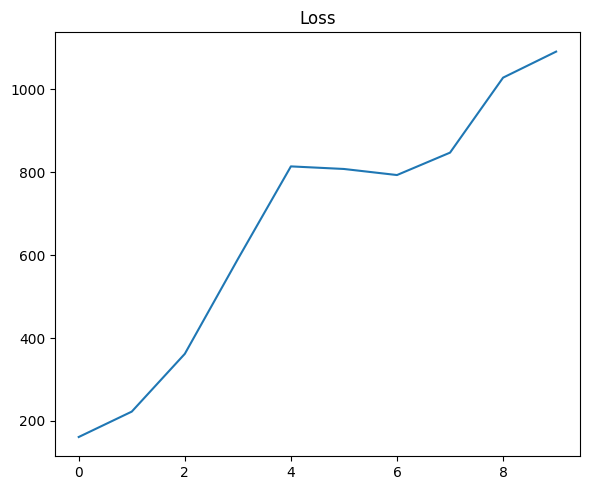

In [507]:
fig, axs = plt.subplots(ncols=1, figsize=(6, 5))
axs.set_title("Loss")
loss_moving_average = (
    np.convolve(
        losses, np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs.plot(range(len(loss_moving_average)), loss_moving_average)
plt.tight_layout()
plt.show()

For cartpole rewards are assigned for the time spent in a non-terminal state. The episode length and rewards will be identical in this case.

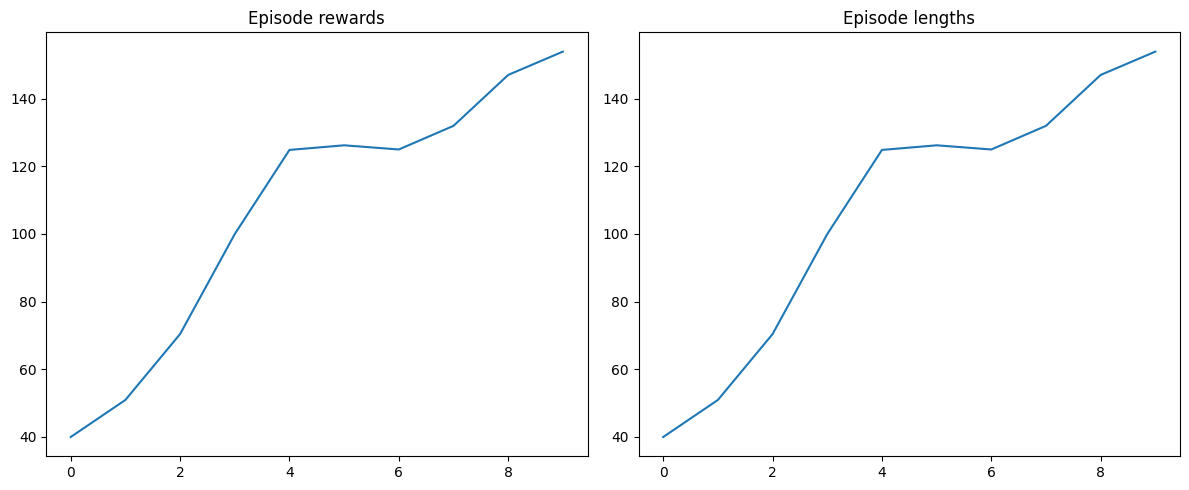

In [508]:
# Code used from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/#visualizing-the-training
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env_returns).mean(axis=1), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env_steps).mean(axis=1), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

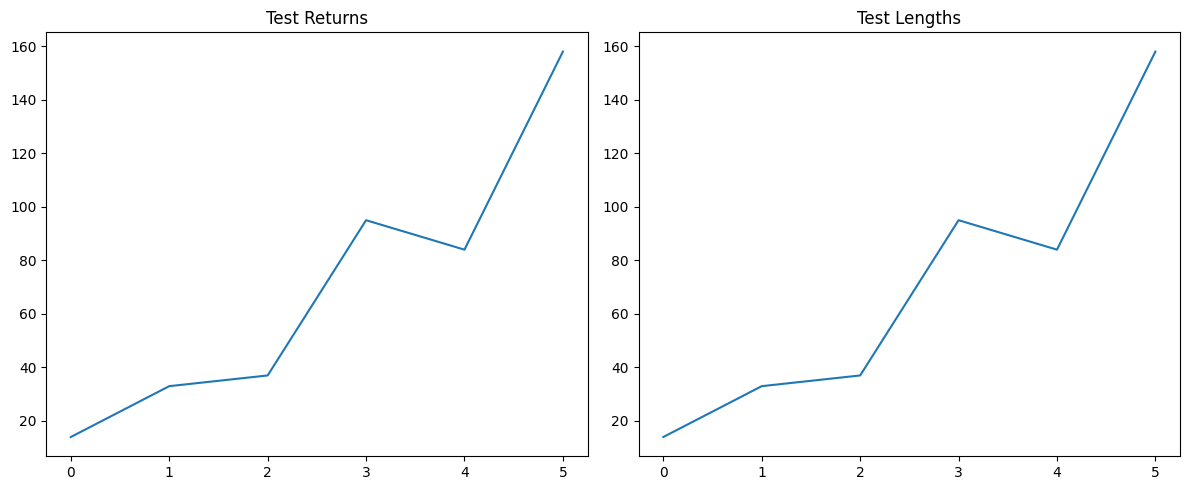

In [509]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Test Returns")
axs[0].plot(range(len(test_returns)), test_returns)
axs[1].set_title("Test Lengths")
axs[1].plot(range(len(test_steps)), test_steps)
plt.tight_layout()
plt.show()

## Testing Videos

### Test Episode 0

In [510]:
test_episode = 0
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 0 Return: 14.0


In [511]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 1

In [512]:
test_episode = 1
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 1 Return: 33.0


In [513]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 2

In [514]:
test_episode = 2
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 2 Return: 37.0


In [515]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 3

In [516]:
test_episode = 3
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 3 Return: 95.0


In [517]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 4

In [518]:
test_episode = 4
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 4 Return: 84.0


In [519]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 5

In [520]:
test_episode = 5
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 5 Return: 158.0


In [521]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")